In [1]:
def get_best_action(actions):
    best_action = 0
    max_action_value = 0
    for i in range(len(actions)):
        cur_action_value = get_action_value(actions[i])
        if cur_action_value > max_action_value:
            best_action = i
            max_action_value = cur_action_value
    return best_action

In [2]:
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt

n = 10
probs = np.random.rand(n)
eps = 0.1

In [3]:
def get_reward(prob, n=10):
    reward = 0
    for i in range(n):
        if random.random() < prob:
            reward += 1
    return reward

In [4]:
reward_test = [get_reward(0.7) for _ in range(2000)]

In [5]:
np.mean(reward_test)

6.9915

In [6]:
sum = 0
x = [4, 5, 6, 7]
for j in range(len(x)):
    sum += x[j]
sum

22

(array([  3.,  14.,  82., 224., 378., 528., 469., 249.,  53.]),
 array([ 2.        ,  2.88888889,  3.77777778,  4.66666667,  5.55555556,
         6.44444444,  7.33333333,  8.22222222,  9.11111111, 10.        ]),
 <BarContainer object of 9 artists>)

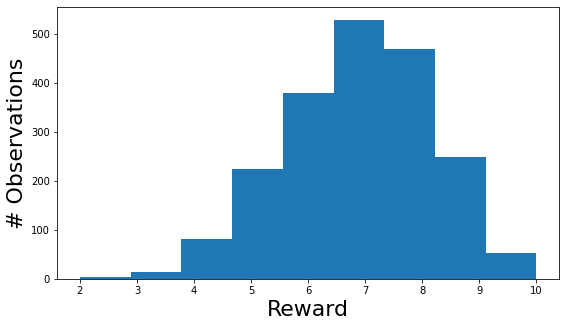

In [7]:
plt.figure(figsize=(9, 5))
plt.xlabel("Reward", fontsize=22)
plt.ylabel("# Observations", fontsize=22)
plt.hist(reward_test, bins=9)

In [8]:
record = np.zeros((n,2))

In [9]:
def get_best_arm(record):
    arm_index = np.argmax(record[:, 1], axis=0)
    return arm_index

In [10]:
def update_record(record, action, r):
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record

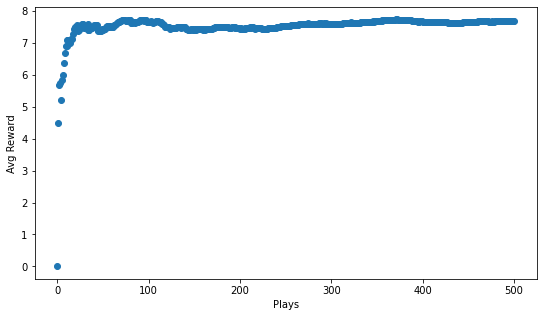

In [11]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Plays")
ax.set_ylabel('Avg Reward')
fig.set_size_inches(9, 5)
rewards = [0]
for i in range(500):
    if random.random() > 0.2:
        choice = get_best_arm(record)
    else:
        choice = np.random.randint(10)
    r = get_reward(probs[choice])
    record = update_record(record, choice, r)
    mean_reward = ((i+1) * rewards[-1] + r) / (i+2)
    rewards.append(mean_reward)
ax.scatter(np.arange(len(rewards)), rewards)

In [12]:
def softmax(av, tau=1.12):
    softm = (np.exp(av / tau) / np.sum(np.exp(av / tau)))
    return softm

In [13]:
probs = np.random.randn(n)
record = np.zeros((n,2))

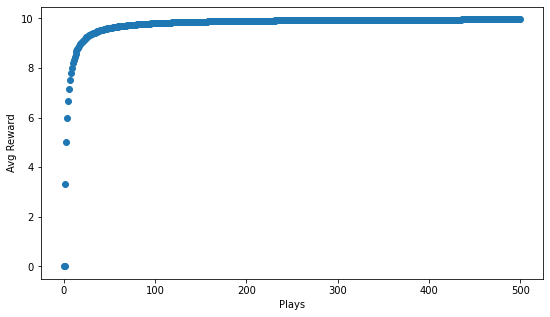

In [14]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9, 5)
rewards = [0]
for i in range(500):
    p = softmax(record[:, 1], tau=0.7)
    choice = np.random.choice(np.arange(n), p=p)
    r = get_reward(probs[choice])
    record = update_record(record, choice, r)
    mean_reward = ((i+1) * rewards[-1] + r) / (i+2)
    rewards.append(mean_reward)
ax.scatter(np.arange(len(rewards)), rewards)

In [15]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
        
    def init_distribution(self, arms):
        self.bandit_matrix = np.random.rand(arms, arms)
    
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward
    
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0, self.arms)
        
    def get_reward(self, arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
    
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [16]:
import numpy as np
import torch

arms = 10
N, D_in, H, D_out = 1, arms, 100, arms

In [17]:
env = ContextBandit(arms=10)
state = env.get_state()
reward = env.choose_arm(1)
print(state)
print(reward)

3
1


In [18]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU(),
)

In [19]:
loss_fn = torch.nn.MSELoss()

In [20]:
env = ContextBandit(arms)

In [21]:
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

In [22]:
def running_mean(x, N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

In [23]:
def train(env, epochs=5000, learning_rate=1e-2):
    cur_state = torch.Tensor(one_hot(arms, env.get_state()))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    rewards = []
    for i in range(epochs):
        y_pred = model(cur_state)
        av_softmax = softmax(y_pred.data.numpy(), tau=2.0)
        av_softmax /= av_softmax.sum()
        choice = np.random.choice(arms, p=av_softmax)
        cur_reward = env.choose_arm(choice)
        one_hot_reward = y_pred.data.numpy().copy()
        one_hot_reward[choice] = cur_reward
        reward = torch.Tensor(one_hot_reward)
        rewards.append(cur_reward)
        loss = loss_fn(y_pred, reward)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cur_state = torch.Tensor(one_hot(arms, env.get_state()))
    return np.array(rewards)

In [24]:
rewards = train(env)

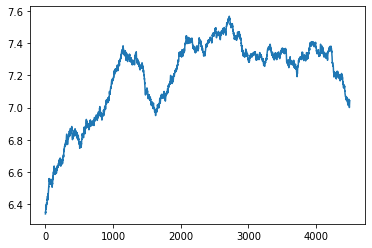

In [25]:
plt.plot(running_mean(rewards, N=500))